#**Imports**

The project is implemented using [PyTorch](https://pytorch.org/) framework.

In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import random
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image
from torchvision import models
from torchvision import transforms as T

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [2]:
torch.backends.cudnn.deterministic = True 
# check if training using GPU is possible
torch.cuda.is_available()

True

#**Downloading dataset from Kaggle to Google Drive**

Link to the Dataset on Kaggle: [MyPaintBrushstrokes](https://www.kaggle.com/reiinakano/mypaint_brushstrokes). 

Consists of $78$ episode files, detailed description of which is given in the repository of the project: https://github.com/Olllga/DM_project.

The routine to print the dataset samples is provided below.

In [3]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
# folder, created in advance in the Google Drive and containing kaggle.json
project_folder = '/content/gdrive/MyDrive/Kaggle/NaturalPainters' # for parent email
#project_folder = '/content/gdrive/MyDrive/NaturalPainters' # for alternative emails
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [8]:
# dive into folder
%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
#%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/MyDrive/Kaggle/NaturalPainters


In [9]:
# path to save final generator weights
generator_path = project_folder + '/models/generator/generator_'
# path to save progress of generated strokes
gen_strokes_path = project_folder + '/images/gen_strokes_images/generator/generator_'
# path to save generator loss
plots_path = project_folder + '/images/loss_plots/generator_'

In [10]:
# download dataset from the given Kaggle page to the current folder
# to be executed just once
# !kaggle datasets download -d reiinakano/mypaint_brushstrokes

In [11]:
# data is currently dowloaded as a zip-folder, we need to unzip it
# to be executed just once
# !unzip \*.zip  && rm *.zip

In [12]:
# for repeatability of the experiments
current_best = True
if current_best:
    SEED = 4
else:
    SEED = random.randint(1, 1000)
print(f'Series of experiments corresponding to a SEED = {SEED} be recreated.')

Series of experiments corresponding to a SEED = 4 be recreated.


In [13]:
# utility for automatic generation of unique paths for saving
def generate_path(epochs):
    # to avoid overwriting while saving models
    dt = datetime.datetime.now().replace(second = 0, microsecond = 0)

    save_path = str(dt).strip() + f'_{epochs}e_{SEED}seed'

    return gen_strokes_path + save_path + '.png', generator_path + save_path + '.pth', plots_path + save_path + '.png'

#**Show Dataset**

In [14]:
# data is stored in the 'episodes_i.npz' format, where i is in {0,...,77}
# this routine loads desired 'episodes_i.npz' for a particular i
# data will be loaded in the dictionary with two fields: 'strokes' and 'actions'
def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

In [15]:
# example 'episodes_i.npz' for i = 0, takes 196.3MB
current_npz = 'episodes_0.npz'

strokes, actions = load_data(current_npz)
print(f'Strokes are {strokes.shape[0]} images with img_width = {strokes.shape[1]}, img_height = {strokes.shape[2]} and n_channels = {strokes.shape[3]}.')
print(f'Actions are {actions.shape[0]} arrays of dimension {actions.shape[1]}.')

Strokes are 100000 images with img_width = 64, img_height = 64 and n_channels = 3.
Actions are 100000 arrays of dimension 12.


In [16]:
# printing routine for images in 'strokes'
def print_data(strokes, 
               figsize = [10, 5], nrows = 2, ncols = 6,
               savepath = None):

    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)

    for i, ax in enumerate(axes.flat):
        img = strokes[i]
        ax.imshow(img)
        ax.set_title('Stroke ' + str(i + 1))

    plt.tight_layout(True)

    if(savepath):
        plt.savefig(savepath, dpi = 200)
        print(f'Images were saved to {savepath}.\n')

    print(f'Example of {nrows * ncols} strokes:\n')
    plt.show()

Images were saved to /content/gdrive/MyDrive/Kaggle/NaturalPainters/images/readme_images/dataset_examples.

Example of 12 strokes:



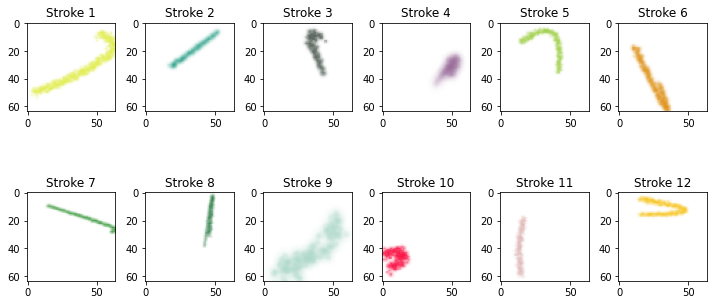

Example of 12 actions:

[[0.70163  0.30781  0.905674 0.382132 ... 0.327325 0.801232 0.132051 0.791512]
 [0.286395 0.565084 0.509936 0.343041 ... 0.463403 0.827277 0.10558  0.170216]
 [0.882056 0.469463 0.533015 0.174413 ... 0.358329 0.693955 0.602135 0.246814]
 [0.361594 0.893709 0.828945 0.408551 ... 0.560948 0.591296 0.712416 0.049876]
 ...
 [0.210662 0.909512 0.665188 0.632399 ... 0.783824 0.147759 0.905845 0.770463]
 [0.792833 0.392336 0.247886 0.700524 ... 0.280456 0.02041  0.702323 0.898893]
 [0.918944 0.082216 0.216768 0.610269 ... 0.695325 0.237305 0.939507 0.850217]
 [0.283974 0.291432 0.758155 0.204911 ... 0.078169 0.244963 0.080239 0.511231]]


In [17]:
# print first n_elem data samples
n_elem = 12
print_data(strokes[:n_elem], savepath = project_folder + '/images/readme_images/dataset_examples')
# to print corresponding numerical arrays (control inputs for painting) in 'actions'
print(f'Example of {n_elem} actions:\n')
print(actions[:n_elem])

In [18]:
# function that creates from strokes and actions tensor dataset appropriate as input to dataloader
def create_dataset(current_npz):

    strokes, actions = load_data(current_npz)
    print(f'Strokes shape is {strokes.shape}.')
    print(f'Actions shape is {actions.shape}.')

    # convert to tensor type and reshape from (H x W x C) to (C x H x W)
    strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
    # convert to tensor type and specify dtype
    actions = torch.stack([torch.from_numpy(action).float() for action in actions])
    
    return TensorDataset(strokes, actions)

# **Generator**

This notebook is devoted to the Generator part only.

**Goal:** to pre-train the best possible Generator to be later loaded and used in the GAN.

## **Generator Model**

Defining the model layers.

In [19]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
        super(Generator, self).__init__()
      
        # we want to obtain 64 x 64 images
        self.out_features = img_height * img_width

        # (12, 64 x 64) = (12, 4096), 12 - shape of each action
        self.lin = nn.Linear(in_features, self.out_features)
        # (4096, 512), 512 - downsampling hparam
        self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                        kernel_size = (4, 4), stride = (1, 1), bias = False)
        self.norm1 = nn.BatchNorm2d(num_features) # 512
        # (512, 256)
        self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm2 = nn.BatchNorm2d(num_features) # 256
        # (256, 128)
        self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm3 = nn.BatchNorm2d(num_features) # 128
        # (128, 64)
        self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm4 = nn.BatchNorm2d(num_features) # 64
        # (64, 64)
        self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                        kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
        self.norm5 = nn.BatchNorm2d(num_features) # 64
        # (64, 3)
        self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
        # fully-convolutional layer
        x = self.lin(x)
        # CNN: all non-residual convolutional layers are followed by spatial batch normalization and ReLU nonlinearities 
        # with the exception of the output layer: uses a scaled tanh to ensure that the output image has pixels in range [0, 255]
        x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
        x = self.norm1(x)
        x = F.relu(self.conv2(x), inplace = True)
        x = self.norm2(x)
        x = F.relu(self.conv3(x), inplace = True)
        x = self.norm3(x)
        x = F.relu(self.conv4(x), inplace = True)
        x = self.norm4(x)
        x = F.relu(self.conv5(x), inplace = True)
        x = self.norm5(x)

        return torch.tanh(self.conv6(x))

In [20]:
# to check created model
generator = Generator(12, 64, 64, 512, 3)
generator

Generator(
  (lin): Linear(in_features=12, out_features=4096, bias=True)
  (conv1): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [21]:
# debug cell
# just to check generator on the output of the dataloader

# current_npz = 'episodes_1.npz'
# dataset = create_dataset(current_npz)
# dataloader = DataLoader(dataset, batch_size = 256, shuffle = False)

# for (strokes_batch, actions_batch) in dataloader:
#   print(actions_batch)
#   break
# generator(actions_batch).shape

## **Feature Extractor**

To train the Generator, we need to compute the **Pereptual Loss:** https://arxiv.org/abs/1603.08155.

In turn, for that we need to load **pre-trained Feature Extractor**. Choice of the Extractor $-$ one of the hyperparameters of the pipeline.

19-layers VGG (**VGG-19**) with batch normalization pre-trained on ImageNet: https://arxiv.org/pdf/1409.1556.pdf has been chosen.

In [22]:
# debug cell
# to see all vgg19_bn layers and indices of chosen for feature extraction ones

# if torch.cuda.is_available():
#    extractor = models.vgg19_bn(pretrained = True, progress = True).features.cuda().eval()
# else:
#     extractor = models.vgg19_bn(pretrained = True, progress = True).features.eval()
# requires_grad(extractor, False)
# blocks = [i-1 for i,o in enumerate(children(extractor)) if isinstance(o, nn.MaxPool2d)]
# print(blocks, blocks[2:])

In [23]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 lambda_s,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights # hparam
      self.lambda_s = lambda_s # weighting factor for style reconstruction loss
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor() # load Feature Extractor 

      # return Hooks that store activations of all modules in self.stored
      # function that creates a Hook for all passed modules that simply stores the output of the layers 
      # we take only modules of interest
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):

        print('\nDownload VGG19 (batch normalized) as pre-trained.\n')
        # evaluation regime, no need to re-train
        extractor = models.vgg19_bn(pretrained = True, progress = True).features.eval()

        if self.device == 'cuda':
            extractor = extractor.cuda()

        # don't want to compute gradients
        requires_grad(extractor, False)

        # features and list of indices of layers with activations (only last ones for high-level features)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    # Gram matrix G is used to compute Style Reconstruction Loss
    # C x H x W - image size
    # features - C-dimensional features for each cell on H x W image grid
    # G is proportional to the uncentered covariance of the C-dimensional features, treating each grif location independently
    # idea - captures information about which features tend to activate together
    def gram_matrix(self, input):

        (batch_size, c, h, w) = input.size()
        # Gram matrix can be computed efficiently by reshaping into (c, hw)
        features = input.view(batch_size, c, h * w)
        G = features @ features.transpose(1, 2)
        # C x H x W is a normalizing factor
        return G.div(c * h * w)

    # where the perceptual loss is computed
    def forward(self, gen_stroke, true_stroke):

        # put extracted features of the generated image into storage
        self.feature_extractor(gen_stroke)
        # create list of features of each layer taking them from storage
        gen_stroke_features = [out for out in self.outputs.stored]
        
        # repeat procedure for the true image
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        # weighted sum of Feature Reconstruction Loss, Style Reconstruction Loss and 
        self.loss = []
        
        # Feature Reconstruction Loss
        # penalizes deviations in content and overall spacial structure
        # computed as MAE between feature maps with weight of objective lambda_c
        # lambda_c is a list of weights - different for each level of feature maps, it is stored in self.layers_weights
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight 
                        for gen_layer, true_layer, weight in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        
        # Style Reconstruction Loss
        # penalizes differences in style: colors, textures, exact shapes, common patterns, etc
        # computed as MAE between gram matriceswith weight of objective lambda_s
        # lambda_s is a list of weights - different for each level of freature maps
        # but in our case lambda_s is a constant factor intended to tweak importance between Feature and Style Reconstruction Losses
        # style_loss_weight[i] = feature_loss_weight[i]^2 * lambda_s
        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * self.lambda_s 
                      for gen_layer, true_layer, weight  in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]

        # Pixel Loss
        # encourages the pixels of the generated image to exactly match the pixels of the target image
        # computed as MAE between two images
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        self.outputs.remove()

#**Training**

## **Trainer Class**

In [24]:
class Trainer():

        def __init__(self, 
                    transforms,
                    generator: nn.Module,
                    feature_extractor: nn.Module,
                    optimizer: torch.optim,
                    epochs: int = 5,
                    gpu: bool = False):
            super(Trainer, self).__init__()

            self.transforms = transforms # for strokes: casts type to float to perform rescaling and then rescales from [0, 255] to [0, 1]
            self.generator = generator # get model to train
            self.feature_extractor = feature_extractor # get feature extractor to compute perceptual loss
            self.optimizer = optimizer # get optimizer to perform training
            self.epochs = epochs
            self.gpu = gpu

        def train(self,
                dataloader,
                print_interval: int = 50,
                save_img_path: str = '',
                save_model_path: str = '',
                verbose: bool = True):
            
            # empty canvas base to collect images of generated over training strokes
            train_gen_strokes = torch.ones_like(dataloader.sampler.data_source.tensors[0][0], dtype = torch.float32)
            train_loss = [] # to collect losses from all the training steps
            mean_train_loss = [] # to collect losses averaged over time interval starting from the beginning up to current step

            print('-'*100)
            print('START OF TRAINING\n')
            for epoch in range(self.epochs):
                # regime upgrading gradients
                self.generator.train()

                epoch_loss = [] # to collect epoch losses
                # empty canvas base to collect images of generated over epoch strokes
                epoch_gen_strokes = torch.ones_like(dataloader.sampler.data_source.tensors[0][0], dtype = torch.float32)

                # procedures inside are performed batch-by-batch
                for i, (stroke, action) in enumerate(dataloader):

                    # image rescaling
                    stroke = torch.stack([self.transforms(s) for s in stroke])

                    if self.gpu:
                        action = action.cuda()
                        stroke = stroke.cuda()

                    # set the gradients of optimized tensor to zero
                    self.optimizer.zero_grad()

                    # generate batch of images
                    gen_stroke = self.generator(action)
                    # compute perceptual loss between generated and true strokes
                    cur_loss = self.feature_extractor(gen_stroke, stroke)
                    # compute the gradients
                    cur_loss.backward()
                    # update the values
                    self.optimizer.step()
                    
                    # collect all the announced losses, needed to collect loss history and modulate training process
                    train_loss.append(cur_loss.data.item())
                    epoch_loss.append(cur_loss.data.item())
                    mean_train_loss.append(torch.mean(torch.FloatTensor(train_loss)))
                    
                    # print_interval defines as a desired step to perform printing of intermediate results during training 
                    if ((i % print_interval) == 0) and verbose:
                        # current step
                        print('Epoch {}/{} | Sample {}/{}'.format((epoch + 1), self.epochs,
                                                                (i + 1), len(dataloader)))
                        # current mean losses
                        print(' => Mean Loss of epoch at current step: {:.3f}'.format(torch.mean(torch.FloatTensor(epoch_loss))))
                        print(' => Mean Loss of training at current step: {:.3f}\n'.format(torch.mean(torch.FloatTensor(train_loss))))

                        # to see the generated on this step stroke in comparison with what is desired
                        print('true vs generated stroke:')
                        self.display_img(torch.cat((stroke[0].clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2))

                        print('-'*50)

                        # update of collection of images, generated during epoch, with image, generated at the current step
                        epoch_gen_strokes = torch.cat((epoch_gen_strokes.clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2)
                        # in the beginning we just update empty collection with images of true stroke for each step
                        if epoch == 0:
                            train_gen_strokes = torch.cat((train_gen_strokes.clone().cpu(), stroke[0].clone().cpu()), dim = 2)

                # results of epoch
                print('-'*100)
                print('End of epoch {}'.format(epoch + 1))
                print('examples of generated during epoch strokes:')
                self.display_img(epoch_gen_strokes)
                print('-'*100)
                
                # update of collection of images, generated during training, with collection of images, generated during epoch
                train_gen_strokes = torch.cat((train_gen_strokes, epoch_gen_strokes), dim = 1)

            # results of training
            # saving model weight for loading to GAN
            if save_model_path != '':
                torch.save(self.generator.state_dict(), save_model_path)
                print(f'\nEND OF TRAINING: model is saved to {save_model_path}.\n')

            print('training progress for the examples of generated strokes:')
            self.display_img(train_gen_strokes)

            if save_img_path != '':
                self.save_img(train_gen_strokes, save_img_path)

            # history of losses to be retrieved for loss plots
            return {
                'train_loss': train_loss,
                'mean_train_loss': mean_train_loss}
        
        # method that converts image to PIL and saves with the best possible quality
        def save_img(self, img, save_path, print_info = True):
            to_pil_image(img).save(save_path, optimize = True, subsampling = 0, quality = 100)
            if print_info:
                print(f"\nImage is saved to {save_path}.")
        # method that converts image to PIL and displays
        def display_img(self, img):
            display(to_pil_image(img))

## **Training Playground**

Training is performed using GPU.

Strokes shape is (100000, 64, 64, 3).
Actions shape is (100000, 12).

Download VGG19 (batch normalized) as pre-trained.



Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

----------------------------------------------------------------------------------------------------
START OF TRAINING

Epoch 1/15 | Sample 1/391
 => Mean Loss of epoch at current step: 10.874
 => Mean Loss of training at current step: 10.874

true vs generated stroke:


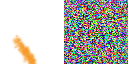

--------------------------------------------------
Epoch 1/15 | Sample 51/391
 => Mean Loss of epoch at current step: 7.931
 => Mean Loss of training at current step: 7.931

true vs generated stroke:


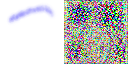

--------------------------------------------------
Epoch 1/15 | Sample 101/391
 => Mean Loss of epoch at current step: 7.258
 => Mean Loss of training at current step: 7.258

true vs generated stroke:


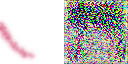

--------------------------------------------------
Epoch 1/15 | Sample 151/391
 => Mean Loss of epoch at current step: 6.813
 => Mean Loss of training at current step: 6.813

true vs generated stroke:


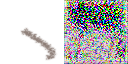

--------------------------------------------------
Epoch 1/15 | Sample 201/391
 => Mean Loss of epoch at current step: 6.464
 => Mean Loss of training at current step: 6.464

true vs generated stroke:


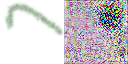

--------------------------------------------------
Epoch 1/15 | Sample 251/391
 => Mean Loss of epoch at current step: 6.200
 => Mean Loss of training at current step: 6.200

true vs generated stroke:


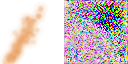

--------------------------------------------------
Epoch 1/15 | Sample 301/391
 => Mean Loss of epoch at current step: 5.981
 => Mean Loss of training at current step: 5.981

true vs generated stroke:


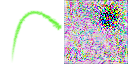

--------------------------------------------------
Epoch 1/15 | Sample 351/391
 => Mean Loss of epoch at current step: 5.807
 => Mean Loss of training at current step: 5.807

true vs generated stroke:


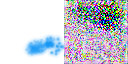

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 1
examples of generated during epoch strokes:


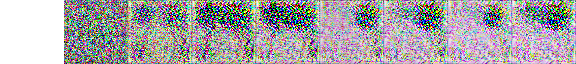

----------------------------------------------------------------------------------------------------
Epoch 2/15 | Sample 1/391
 => Mean Loss of epoch at current step: 4.533
 => Mean Loss of training at current step: 5.682

true vs generated stroke:


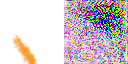

--------------------------------------------------
Epoch 2/15 | Sample 51/391
 => Mean Loss of epoch at current step: 4.504
 => Mean Loss of training at current step: 5.549

true vs generated stroke:


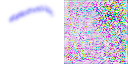

--------------------------------------------------
Epoch 2/15 | Sample 101/391
 => Mean Loss of epoch at current step: 4.441
 => Mean Loss of training at current step: 5.430

true vs generated stroke:


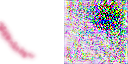

--------------------------------------------------
Epoch 2/15 | Sample 151/391
 => Mean Loss of epoch at current step: 4.383
 => Mean Loss of training at current step: 5.322

true vs generated stroke:


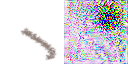

--------------------------------------------------
Epoch 2/15 | Sample 201/391
 => Mean Loss of epoch at current step: 4.331
 => Mean Loss of training at current step: 5.225

true vs generated stroke:


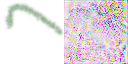

--------------------------------------------------
Epoch 2/15 | Sample 251/391
 => Mean Loss of epoch at current step: 4.281
 => Mean Loss of training at current step: 5.136

true vs generated stroke:


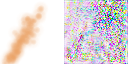

--------------------------------------------------
Epoch 2/15 | Sample 301/391
 => Mean Loss of epoch at current step: 4.228
 => Mean Loss of training at current step: 5.051

true vs generated stroke:


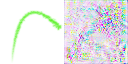

--------------------------------------------------
Epoch 2/15 | Sample 351/391
 => Mean Loss of epoch at current step: 4.173
 => Mean Loss of training at current step: 4.970

true vs generated stroke:


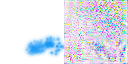

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 2
examples of generated during epoch strokes:


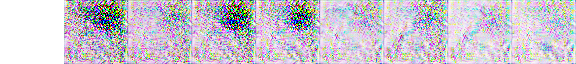

----------------------------------------------------------------------------------------------------
Epoch 3/15 | Sample 1/391
 => Mean Loss of epoch at current step: 3.706
 => Mean Loss of training at current step: 4.905

true vs generated stroke:


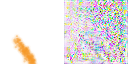

--------------------------------------------------
Epoch 3/15 | Sample 51/391
 => Mean Loss of epoch at current step: 3.626
 => Mean Loss of training at current step: 4.828

true vs generated stroke:


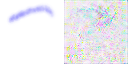

--------------------------------------------------
Epoch 3/15 | Sample 101/391
 => Mean Loss of epoch at current step: 3.588
 => Mean Loss of training at current step: 4.756

true vs generated stroke:


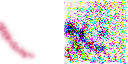

--------------------------------------------------
Epoch 3/15 | Sample 151/391
 => Mean Loss of epoch at current step: 3.532
 => Mean Loss of training at current step: 4.684

true vs generated stroke:


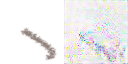

--------------------------------------------------
Epoch 3/15 | Sample 201/391
 => Mean Loss of epoch at current step: 3.438
 => Mean Loss of training at current step: 4.606

true vs generated stroke:


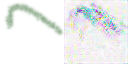

--------------------------------------------------
Epoch 3/15 | Sample 251/391
 => Mean Loss of epoch at current step: 3.359
 => Mean Loss of training at current step: 4.530

true vs generated stroke:


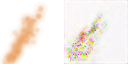

--------------------------------------------------
Epoch 3/15 | Sample 301/391
 => Mean Loss of epoch at current step: 3.258
 => Mean Loss of training at current step: 4.448

true vs generated stroke:


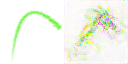

--------------------------------------------------
Epoch 3/15 | Sample 351/391
 => Mean Loss of epoch at current step: 3.170
 => Mean Loss of training at current step: 4.368

true vs generated stroke:


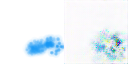

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 3
examples of generated during epoch strokes:


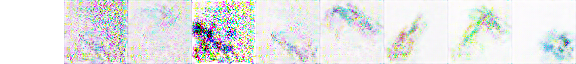

----------------------------------------------------------------------------------------------------
Epoch 4/15 | Sample 1/391
 => Mean Loss of epoch at current step: 2.494
 => Mean Loss of training at current step: 4.307

true vs generated stroke:


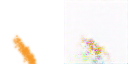

--------------------------------------------------
Epoch 4/15 | Sample 51/391
 => Mean Loss of epoch at current step: 2.558
 => Mean Loss of training at current step: 4.236

true vs generated stroke:


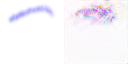

--------------------------------------------------
Epoch 4/15 | Sample 101/391
 => Mean Loss of epoch at current step: 2.516
 => Mean Loss of training at current step: 4.167

true vs generated stroke:


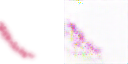

--------------------------------------------------
Epoch 4/15 | Sample 151/391
 => Mean Loss of epoch at current step: 2.475
 => Mean Loss of training at current step: 4.100

true vs generated stroke:


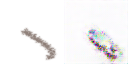

--------------------------------------------------
Epoch 4/15 | Sample 201/391
 => Mean Loss of epoch at current step: 2.441
 => Mean Loss of training at current step: 4.036

true vs generated stroke:


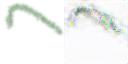

--------------------------------------------------
Epoch 4/15 | Sample 251/391
 => Mean Loss of epoch at current step: 2.408
 => Mean Loss of training at current step: 3.974

true vs generated stroke:


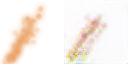

--------------------------------------------------
Epoch 4/15 | Sample 301/391
 => Mean Loss of epoch at current step: 2.384
 => Mean Loss of training at current step: 3.916

true vs generated stroke:


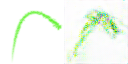

--------------------------------------------------
Epoch 4/15 | Sample 351/391
 => Mean Loss of epoch at current step: 2.358
 => Mean Loss of training at current step: 3.859

true vs generated stroke:


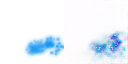

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 4
examples of generated during epoch strokes:


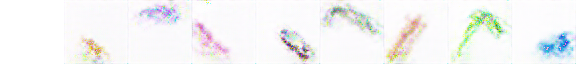

----------------------------------------------------------------------------------------------------
Epoch 5/15 | Sample 1/391
 => Mean Loss of epoch at current step: 2.197
 => Mean Loss of training at current step: 3.816

true vs generated stroke:


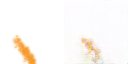

--------------------------------------------------
Epoch 5/15 | Sample 51/391
 => Mean Loss of epoch at current step: 2.145
 => Mean Loss of training at current step: 3.764

true vs generated stroke:


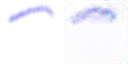

--------------------------------------------------
Epoch 5/15 | Sample 101/391
 => Mean Loss of epoch at current step: 2.135
 => Mean Loss of training at current step: 3.715

true vs generated stroke:


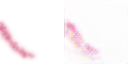

--------------------------------------------------
Epoch 5/15 | Sample 151/391
 => Mean Loss of epoch at current step: 2.119
 => Mean Loss of training at current step: 3.667

true vs generated stroke:


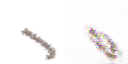

--------------------------------------------------
Epoch 5/15 | Sample 201/391
 => Mean Loss of epoch at current step: 2.108
 => Mean Loss of training at current step: 3.622

true vs generated stroke:


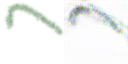

--------------------------------------------------
Epoch 5/15 | Sample 251/391
 => Mean Loss of epoch at current step: 2.093
 => Mean Loss of training at current step: 3.578

true vs generated stroke:


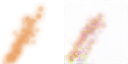

--------------------------------------------------
Epoch 5/15 | Sample 301/391
 => Mean Loss of epoch at current step: 2.081
 => Mean Loss of training at current step: 3.536

true vs generated stroke:


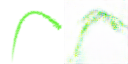

--------------------------------------------------
Epoch 5/15 | Sample 351/391
 => Mean Loss of epoch at current step: 2.068
 => Mean Loss of training at current step: 3.496

true vs generated stroke:


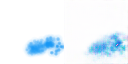

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 5
examples of generated during epoch strokes:


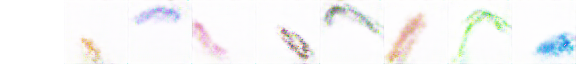

----------------------------------------------------------------------------------------------------
Epoch 6/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.948
 => Mean Loss of training at current step: 3.464

true vs generated stroke:


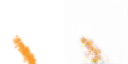

--------------------------------------------------
Epoch 6/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.963
 => Mean Loss of training at current step: 3.427

true vs generated stroke:


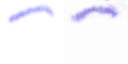

--------------------------------------------------
Epoch 6/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.948
 => Mean Loss of training at current step: 3.391

true vs generated stroke:


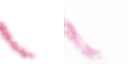

--------------------------------------------------
Epoch 6/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.937
 => Mean Loss of training at current step: 3.356

true vs generated stroke:


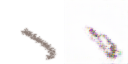

--------------------------------------------------
Epoch 6/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.929
 => Mean Loss of training at current step: 3.322

true vs generated stroke:


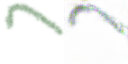

--------------------------------------------------
Epoch 6/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.917
 => Mean Loss of training at current step: 3.289

true vs generated stroke:


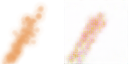

--------------------------------------------------
Epoch 6/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.908
 => Mean Loss of training at current step: 3.257

true vs generated stroke:


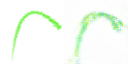

--------------------------------------------------
Epoch 6/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.898
 => Mean Loss of training at current step: 3.227

true vs generated stroke:


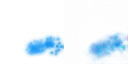

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 6
examples of generated during epoch strokes:


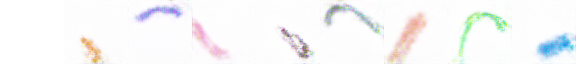

----------------------------------------------------------------------------------------------------
Epoch 7/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.796
 => Mean Loss of training at current step: 3.202

true vs generated stroke:


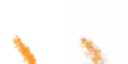

--------------------------------------------------
Epoch 7/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.803
 => Mean Loss of training at current step: 3.173

true vs generated stroke:


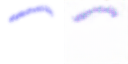

--------------------------------------------------
Epoch 7/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.804
 => Mean Loss of training at current step: 3.145

true vs generated stroke:


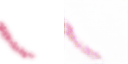

--------------------------------------------------
Epoch 7/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.797
 => Mean Loss of training at current step: 3.118

true vs generated stroke:


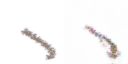

--------------------------------------------------
Epoch 7/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.790
 => Mean Loss of training at current step: 3.091

true vs generated stroke:


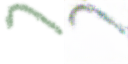

--------------------------------------------------
Epoch 7/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.783
 => Mean Loss of training at current step: 3.066

true vs generated stroke:


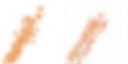

--------------------------------------------------
Epoch 7/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.775
 => Mean Loss of training at current step: 3.041

true vs generated stroke:


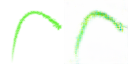

--------------------------------------------------
Epoch 7/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.767
 => Mean Loss of training at current step: 3.016

true vs generated stroke:


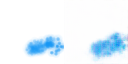

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 7
examples of generated during epoch strokes:


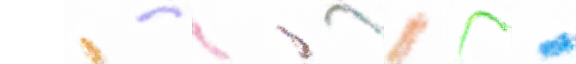

----------------------------------------------------------------------------------------------------
Epoch 8/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.726
 => Mean Loss of training at current step: 2.997

true vs generated stroke:


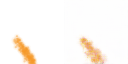

--------------------------------------------------
Epoch 8/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.692
 => Mean Loss of training at current step: 2.973

true vs generated stroke:


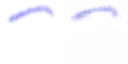

--------------------------------------------------
Epoch 8/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.694
 => Mean Loss of training at current step: 2.951

true vs generated stroke:


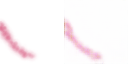

--------------------------------------------------
Epoch 8/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.693
 => Mean Loss of training at current step: 2.929

true vs generated stroke:


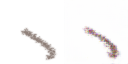

--------------------------------------------------
Epoch 8/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.688
 => Mean Loss of training at current step: 2.908

true vs generated stroke:


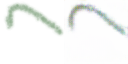

--------------------------------------------------
Epoch 8/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.682
 => Mean Loss of training at current step: 2.887

true vs generated stroke:


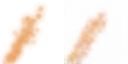

--------------------------------------------------
Epoch 8/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.675
 => Mean Loss of training at current step: 2.866

true vs generated stroke:


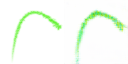

--------------------------------------------------
Epoch 8/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.669
 => Mean Loss of training at current step: 2.846

true vs generated stroke:


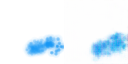

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 8
examples of generated during epoch strokes:


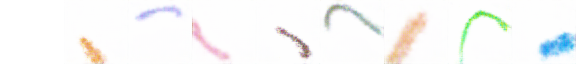

----------------------------------------------------------------------------------------------------
Epoch 9/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.633
 => Mean Loss of training at current step: 2.830

true vs generated stroke:


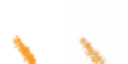

--------------------------------------------------
Epoch 9/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.607
 => Mean Loss of training at current step: 2.811

true vs generated stroke:


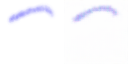

--------------------------------------------------
Epoch 9/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.609
 => Mean Loss of training at current step: 2.793

true vs generated stroke:


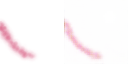

--------------------------------------------------
Epoch 9/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.606
 => Mean Loss of training at current step: 2.774

true vs generated stroke:


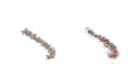

--------------------------------------------------
Epoch 9/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.602
 => Mean Loss of training at current step: 2.757

true vs generated stroke:


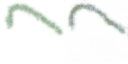

--------------------------------------------------
Epoch 9/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.596
 => Mean Loss of training at current step: 2.739

true vs generated stroke:


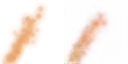

--------------------------------------------------
Epoch 9/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.590
 => Mean Loss of training at current step: 2.722

true vs generated stroke:


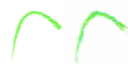

--------------------------------------------------
Epoch 9/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.584
 => Mean Loss of training at current step: 2.705

true vs generated stroke:


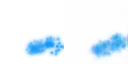

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 9
examples of generated during epoch strokes:


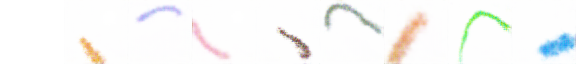

----------------------------------------------------------------------------------------------------
Epoch 10/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.573
 => Mean Loss of training at current step: 2.692

true vs generated stroke:


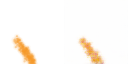

--------------------------------------------------
Epoch 10/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.544
 => Mean Loss of training at current step: 2.676

true vs generated stroke:


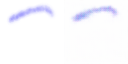

--------------------------------------------------
Epoch 10/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.542
 => Mean Loss of training at current step: 2.660

true vs generated stroke:


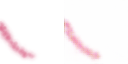

--------------------------------------------------
Epoch 10/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.539
 => Mean Loss of training at current step: 2.645

true vs generated stroke:


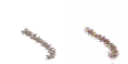

--------------------------------------------------
Epoch 10/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.536
 => Mean Loss of training at current step: 2.630

true vs generated stroke:


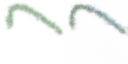

--------------------------------------------------
Epoch 10/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.532
 => Mean Loss of training at current step: 2.615

true vs generated stroke:


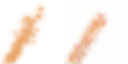

--------------------------------------------------
Epoch 10/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.528
 => Mean Loss of training at current step: 2.601

true vs generated stroke:


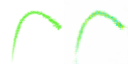

--------------------------------------------------
Epoch 10/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.523
 => Mean Loss of training at current step: 2.586

true vs generated stroke:


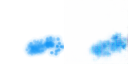

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 10
examples of generated during epoch strokes:


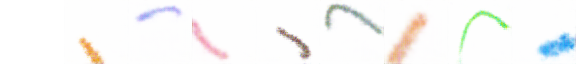

----------------------------------------------------------------------------------------------------
Epoch 11/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.523
 => Mean Loss of training at current step: 2.575

true vs generated stroke:


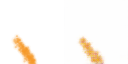

--------------------------------------------------
Epoch 11/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.489
 => Mean Loss of training at current step: 2.561

true vs generated stroke:


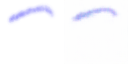

--------------------------------------------------
Epoch 11/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.489
 => Mean Loss of training at current step: 2.548

true vs generated stroke:


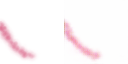

--------------------------------------------------
Epoch 11/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.486
 => Mean Loss of training at current step: 2.535

true vs generated stroke:


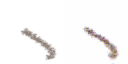

--------------------------------------------------
Epoch 11/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.484
 => Mean Loss of training at current step: 2.522

true vs generated stroke:


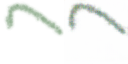

--------------------------------------------------
Epoch 11/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.480
 => Mean Loss of training at current step: 2.509

true vs generated stroke:


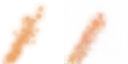

--------------------------------------------------
Epoch 11/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.477
 => Mean Loss of training at current step: 2.497

true vs generated stroke:


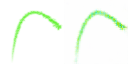

--------------------------------------------------
Epoch 11/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.473
 => Mean Loss of training at current step: 2.484

true vs generated stroke:


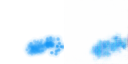

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 11
examples of generated during epoch strokes:


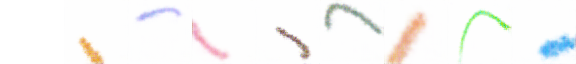

----------------------------------------------------------------------------------------------------
Epoch 12/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.444
 => Mean Loss of training at current step: 2.475

true vs generated stroke:


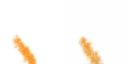

--------------------------------------------------
Epoch 12/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.445
 => Mean Loss of training at current step: 2.463

true vs generated stroke:


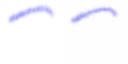

--------------------------------------------------
Epoch 12/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.445
 => Mean Loss of training at current step: 2.451

true vs generated stroke:


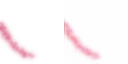

--------------------------------------------------
Epoch 12/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.442
 => Mean Loss of training at current step: 2.440

true vs generated stroke:


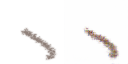

--------------------------------------------------
Epoch 12/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.440
 => Mean Loss of training at current step: 2.429

true vs generated stroke:


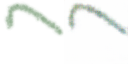

--------------------------------------------------
Epoch 12/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.437
 => Mean Loss of training at current step: 2.418

true vs generated stroke:


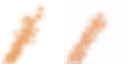

--------------------------------------------------
Epoch 12/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.434
 => Mean Loss of training at current step: 2.407

true vs generated stroke:


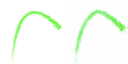

--------------------------------------------------
Epoch 12/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.432
 => Mean Loss of training at current step: 2.396

true vs generated stroke:


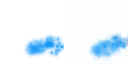

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 12
examples of generated during epoch strokes:


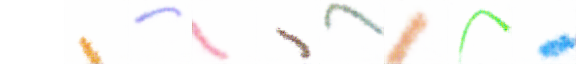

----------------------------------------------------------------------------------------------------
Epoch 13/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.423
 => Mean Loss of training at current step: 2.388

true vs generated stroke:


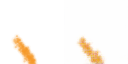

--------------------------------------------------
Epoch 13/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.406
 => Mean Loss of training at current step: 2.377

true vs generated stroke:


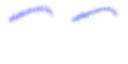

--------------------------------------------------
Epoch 13/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.410
 => Mean Loss of training at current step: 2.367

true vs generated stroke:


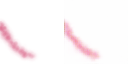

--------------------------------------------------
Epoch 13/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.409
 => Mean Loss of training at current step: 2.357

true vs generated stroke:


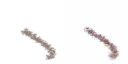

--------------------------------------------------
Epoch 13/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.405
 => Mean Loss of training at current step: 2.348

true vs generated stroke:


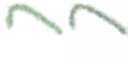

--------------------------------------------------
Epoch 13/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.402
 => Mean Loss of training at current step: 2.338

true vs generated stroke:


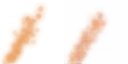

--------------------------------------------------
Epoch 13/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.399
 => Mean Loss of training at current step: 2.328

true vs generated stroke:


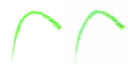

--------------------------------------------------
Epoch 13/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.396
 => Mean Loss of training at current step: 2.319

true vs generated stroke:


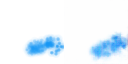

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 13
examples of generated during epoch strokes:


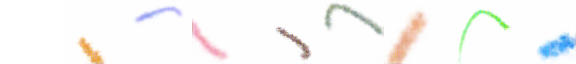

----------------------------------------------------------------------------------------------------
Epoch 14/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.401
 => Mean Loss of training at current step: 2.312

true vs generated stroke:


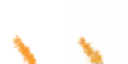

--------------------------------------------------
Epoch 14/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.380
 => Mean Loss of training at current step: 2.303

true vs generated stroke:


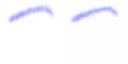

--------------------------------------------------
Epoch 14/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.381
 => Mean Loss of training at current step: 2.294

true vs generated stroke:


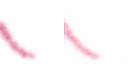

--------------------------------------------------
Epoch 14/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.378
 => Mean Loss of training at current step: 2.285

true vs generated stroke:


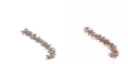

--------------------------------------------------
Epoch 14/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.376
 => Mean Loss of training at current step: 2.276

true vs generated stroke:


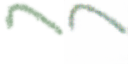

--------------------------------------------------
Epoch 14/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.374
 => Mean Loss of training at current step: 2.268

true vs generated stroke:


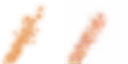

--------------------------------------------------
Epoch 14/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.371
 => Mean Loss of training at current step: 2.259

true vs generated stroke:


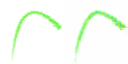

--------------------------------------------------
Epoch 14/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.369
 => Mean Loss of training at current step: 2.251

true vs generated stroke:


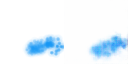

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 14
examples of generated during epoch strokes:


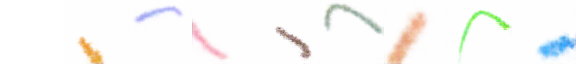

----------------------------------------------------------------------------------------------------
Epoch 15/15 | Sample 1/391
 => Mean Loss of epoch at current step: 1.352
 => Mean Loss of training at current step: 2.244

true vs generated stroke:


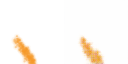

--------------------------------------------------
Epoch 15/15 | Sample 51/391
 => Mean Loss of epoch at current step: 1.351
 => Mean Loss of training at current step: 2.236

true vs generated stroke:


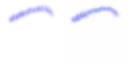

--------------------------------------------------
Epoch 15/15 | Sample 101/391
 => Mean Loss of epoch at current step: 1.352
 => Mean Loss of training at current step: 2.228

true vs generated stroke:


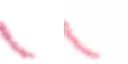

--------------------------------------------------
Epoch 15/15 | Sample 151/391
 => Mean Loss of epoch at current step: 1.352
 => Mean Loss of training at current step: 2.220

true vs generated stroke:


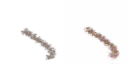

--------------------------------------------------
Epoch 15/15 | Sample 201/391
 => Mean Loss of epoch at current step: 1.350
 => Mean Loss of training at current step: 2.213

true vs generated stroke:


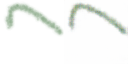

--------------------------------------------------
Epoch 15/15 | Sample 251/391
 => Mean Loss of epoch at current step: 1.348
 => Mean Loss of training at current step: 2.205

true vs generated stroke:


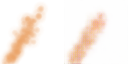

--------------------------------------------------
Epoch 15/15 | Sample 301/391
 => Mean Loss of epoch at current step: 1.345
 => Mean Loss of training at current step: 2.198

true vs generated stroke:


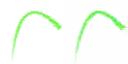

--------------------------------------------------
Epoch 15/15 | Sample 351/391
 => Mean Loss of epoch at current step: 1.342
 => Mean Loss of training at current step: 2.190

true vs generated stroke:


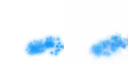

--------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 15
examples of generated during epoch strokes:


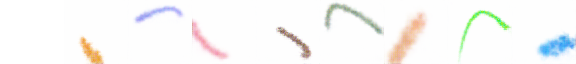

----------------------------------------------------------------------------------------------------

END OF TRAINING: model is saved to /content/gdrive/MyDrive/Kaggle/NaturalPainters/models/generator/generator_2022-02-16 23:49:00_15e_4seed.pth.

training progress for the examples of generated strokes:


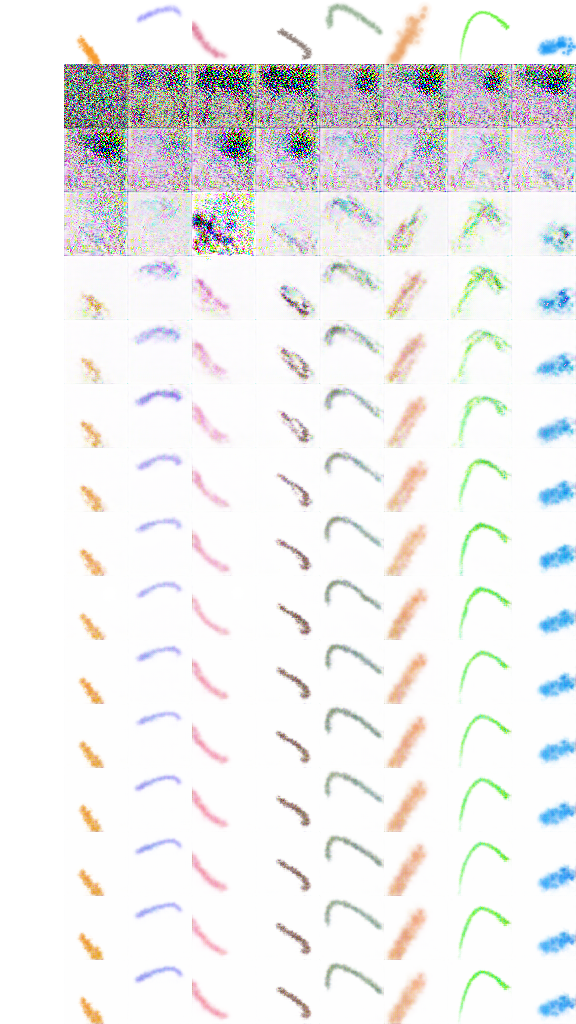


Image is saved to /content/gdrive/MyDrive/Kaggle/NaturalPainters/images/gen_strokes_images/generator/generator_2022-02-16 23:49:00_15e_4seed.png.


In [25]:
# set either repeated or random experiment
torch.manual_seed(SEED)

# set hyperparameters: right pannel provides the playground
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    layers_weights = [5, 15, 2] #@param
    lambda_s = 5000 #@param {type: "slider", min:1, max:5000}
    batch_size = 256 #@param {type: "slider", min:8, max:512, step:8}
    lr = 0.001 #@param {type:"number"}
    betas = (0.5, 0.9) #@param
    epochs = 15 #@param {type:"slider", min:1, max:1000, step:1}
    print_interval = 50 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

# define device for training
gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

# get the dataset
current_npz = 'episodes_1.npz'
dataset = create_dataset(current_npz)

# create the loader to train by batches
dataloader = DataLoader(dataset, 
                        batch_size = hparams.batch_size, 
                        shuffle = False)

# create model instance of Generator
generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

generator.to(device)

# create model instance of Feature Extractor
feature_extractor = FeatureExtractor(hparams.layers_weights,
                                     hparams.lambda_s, 
                                     device)

# create an instance of optimizer
optimizer = optim.Adam(generator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

# transformations on strokes
strokes_tfms = T.Compose([T.Lambda(lambda x: x.float()),
                          T.Lambda(lambda x: x.div_(255))])

# create model instance of Trainer
trainer = Trainer(strokes_tfms,
                  generator,
                  feature_extractor,
                  optimizer,
                  epochs = hparams.epochs,
                  gpu = gpu)

# generate paths for saving
img_path, gen_path, loss_path = generate_path(hparams.epochs)
# call the training method with the desired saving paths
train_history = trainer.train(dataloader, 
                              print_interval = hparams.print_interval,
                              save_img_path = img_path,
                              save_model_path = gen_path)

## **Loss History**

In [26]:
# plot and save train loss
def plot_loss(save_loss_path = '', model_name = 'Model',
              xlim = [], ylim = [], color = 'darkcyan', alpha = 0.5,
              epochs = 15):

    fig, axs = plt.subplots()

    plt.plot(train_history['train_loss'], '-', color = color, alpha = alpha)
    plt.plot(train_history['mean_train_loss'], '--', color = color)

    plt.title(f'{model_name} loss collected over {epochs} epochs')
    plt.ylabel('Loss')
    plt.xlabel('Step (dataset size / batch size * num epochs)')

    if xlim != []:
        plt.xlim(xlim)
    if ylim != []:
        plt.ylim(ylim)

    plt.legend(['train loss', 'mean train loss'], loc = 'upper right')

    if save_loss_path != '':
        fig.savefig(save_loss_path, bbox_inches = 'tight')

    plt.show()

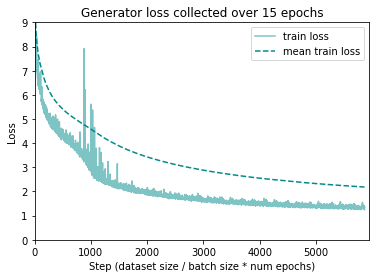

In [27]:
plot_loss(loss_path, 'Generator', 
          xlim = [-1, 5950], ylim = [0, 9], 
          epochs = hparams.epochs)